## Numerical analysis using Long Short Term Memory (LSTM) ##
### 1. import statements and prepare stock data from csv for training ###
This version uses tensorflow to model close price of a stock. 5 yr of MSFT data is used in training 

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from datetime import datetime

#reference https://www.youtube.com/watch?v=CbTU92pbDKw and https://www.youtube.com/watch?v=q_HS4s1L8UI 

In [94]:
# use DataPreprocessing if file does not exist
prefix = datetime.today().strftime('%Y-%m-%d')
ticker= "MSFT" #"AAPL" #"^SPX" #"TSLA"

data = pd.read_csv(prefix+'-'+ticker+'.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2020-02-27,163.320007,167.029999,157.979996,158.179993,151.406509,93174900,MSFT
1,2020-02-28,152.410004,163.710007,152.000000,162.009995,155.072495,97012700,MSFT
2,2020-03-02,165.309998,172.919998,162.309998,172.789993,165.390915,71030800,MSFT
3,2020-03-03,173.800003,175.000000,162.259995,164.509995,157.465469,71677000,MSFT
4,2020-03-04,168.490005,170.699997,165.619995,170.550003,163.246841,49814400,MSFT
...,...,...,...,...,...,...,...,...
1249,2025-02-14,407.790009,408.910004,405.880005,408.429993,407.612671,22758500,MSFT
1250,2025-02-18,408.000000,410.600006,406.500000,409.640015,408.820282,21423100,MSFT
1251,2025-02-19,407.880005,415.489990,407.649994,414.769989,413.940002,24114200,MSFT
1252,2025-02-20,415.290009,419.309998,412.540009,416.130005,416.130005,23508700,MSFT


In [95]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

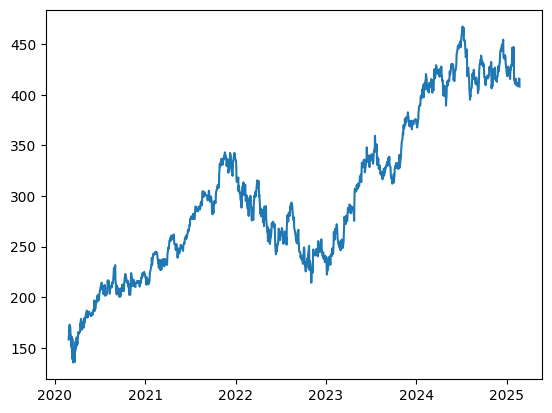

In [96]:
# only use close column
data = data[['Date', 'Close']]
pd.options.mode.chained_assignment = None
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [97]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

# construct dataframe with 7-day lookback
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)

shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2020-03-09,150.619995,161.570007,166.270004,170.550003,164.509995,172.789993,162.009995,158.179993
2020-03-10,160.919998,150.619995,161.570007,166.270004,170.550003,164.509995,172.789993,162.009995
2020-03-11,153.630005,160.919998,150.619995,161.570007,166.270004,170.550003,164.509995,172.789993
2020-03-12,139.059998,153.630005,160.919998,150.619995,161.570007,166.270004,170.550003,164.509995
2020-03-13,158.830002,139.059998,153.630005,160.919998,150.619995,161.570007,166.270004,170.550003
...,...,...,...,...,...,...,...,...
2025-02-14,408.429993,410.540009,409.040009,411.440002,412.220001,409.750000,415.820007,413.290009
2025-02-18,409.640015,408.429993,410.540009,409.040009,411.440002,412.220001,409.750000,415.820007
2025-02-19,414.769989,409.640015,408.429993,410.540009,409.040009,411.440002,412.220001,409.750000


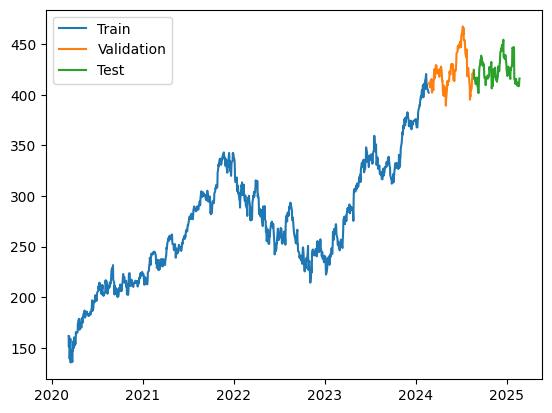

In [98]:
dates=shifted_df.index
shifted_df=shifted_df.to_numpy()
X = shifted_df[:,1:-1].reshape((len(dates), shifted_df.shape[1]-2, 1))
y = shifted_df[:, 1]
X = dc(np.flip(X, axis=1))
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

### 2. Split data into training and test sets with a 80/20 split ###


### 3. Convert the numpy arrays to PyTorch tensors ###
need to reshape, and add .to(device)

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((7, 1)),  # 7 days 
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 76414.2266 - mean_absolute_error: 270.7337 - val_loss: 176576.4062 - val_mean_absolute_error: 419.8506
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 74605.1875 - mean_absolute_error: 267.3644 - val_loss: 166218.3906 - val_mean_absolute_error: 407.3285
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 66697.5312 - mean_absolute_error: 251.6791 - val_loss: 138685.9531 - val_mean_absolute_error: 372.0002
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 46930.7695 - mean_absolute_error: 208.1501 - val_loss: 92570.6094 - val_mean_absolute_error: 303.7562
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 19391.3633 - mean_absolute_error: 126.6452 - val_loss: 44171.7578 - val_mean_absolute_error: 209.4513
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5158.4790 - mean_absolute_error: 56.6914 - val_loss: 23784.4004 - val_mean_absolute_error: 153.2460
Epoch 7/100
32/32 ━━━━━━━━━━━━━

### 4. Eval model ###

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


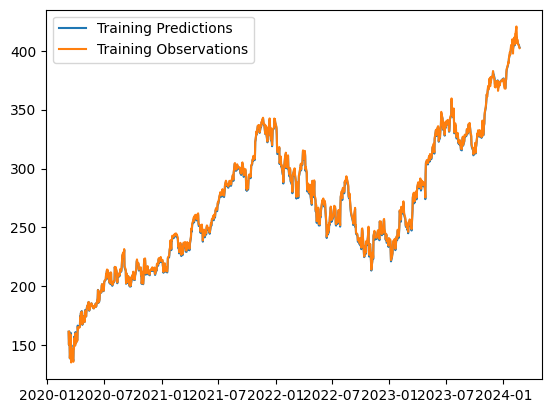

In [100]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


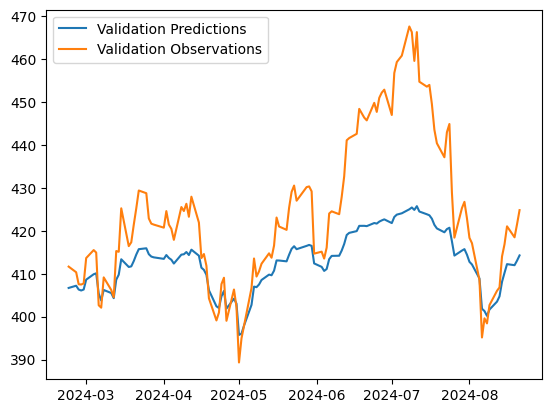

In [101]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


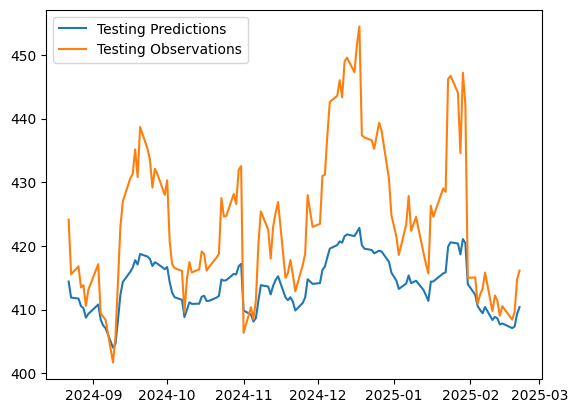

In [102]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

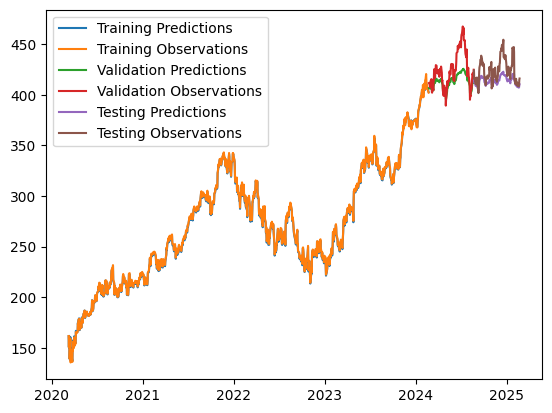

In [103]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])